##############################
 
Starting iteration 1
OK - Graph created
Creating training and test set...
OK - Training and test set created
Node2Vec...


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

OK - Model created
Edge embedding...
OK - Embedding done
Logistic regression - Computing scores...
Testing...
	ROC AUC score for Hadamard 0.9497325452348294

	ROC AUC score fro L1 0.9516118672263957

	ROC AUC score fro L2 0.9525984954822285

Iteration 1 finished

	Accuracy for Hadamard: 0.949180587981957

	Accuracy for L1: 0.9546546682684679

	Accuracy for L2: 0.9553346782419475



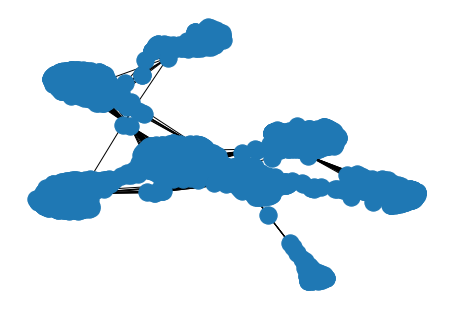

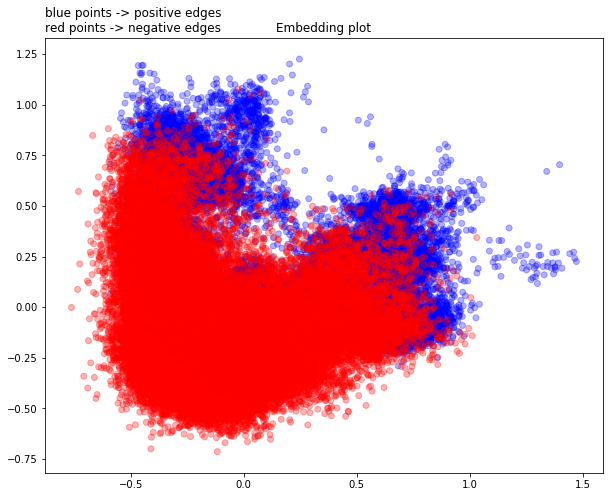

In [5]:
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt
import numpy as np
import urllib
import csv
import math 
import random
from node2vec.edges import HadamardEmbedder
import sklearn
import os
import gensim
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import argparse


# Embedding functions
edge_functions = {
    "hadamard": lambda a, b: a * b,
    "average": lambda a, b: 0.5 * (a + b),
    "L1": lambda a, b: np.abs(a - b),
    "L2": lambda a, b: np.abs(a - b) ** 2,
}

# utility function - converts .embeddings file to python dictionary
def embeddings_to_dictionary(emb_file_name):

    dictionary = {}

    with open(emb_file_name, 'r') as f:

        next(f) # skip first line (file comment line)
        for line in f:
            elements = line.split(' ')
            node_id = elements.pop(0)
            embedding = []
            for e in elements:
                embedding.append(float(e))

            dictionary[node_id] = embedding

    return dictionary     


def create_test_and_training_set(positive_training_set, percentage, negative_percentage, min_degree):

    # Test graph
    positive_test_set = nx.Graph()
    positive_test_set.add_nodes_from(positive_training_set)

    # Generate negative samples for training
    all_negative_samples = list(nx.non_edges(positive_training_set))
    accetable = [True for i in range(len(all_negative_samples))]

    node_number = positive_training_set.number_of_nodes()
    node_list = positive_training_set.nodes()

    for node in node_list:

        percent = int(round((percentage * len(positive_training_set.edges(node)))))
        edges = list(positive_training_set.edges(node))
        counter = 0
        edge_count = len(edges)
		
        for attempt in range(edge_count):

            if len(edges) > 0:
                u, v = edges.pop(random.randrange(len(edges)))

                if counter < percent:
                    if (positive_training_set.degree[u] > min_degree and positive_training_set.degree[v] > min_degree):
                        positive_test_set.add_edge(u,v)
                        positive_training_set.remove_edge(u,v)
                        counter += 1
                    
                else:
                    break
            
            else:
                break


    ##########################
    # Negative samples for training
    negative_edges_for_training = []

    for i in range(int((2*negative_percentage) * len(positive_training_set.edges()))) :
        index = random.randint(0, len(all_negative_samples))
        negative_edges_for_training.append(all_negative_samples[index])
        accetable[index] = False

    negative_training_set = nx.Graph()
    negative_training_set.add_nodes_from(positive_training_set)
    negative_training_set.add_edges_from(negative_edges_for_training)
    #############################

    
    ############################
    # Negative samples for test
    negative_edges_for_test = []

    i = 0
    while i < (int((2*negative_percentage) * len(positive_training_set.edges()))) :
        
        index = random.randint(0, len(all_negative_samples))
        
        if accetable[index] :
            negative_edges_for_test.append(all_negative_samples[index])
            accetable[index] = False
            i += 1

    negative_test_set = nx.Graph()
    negative_test_set.add_nodes_from(positive_training_set)
    negative_test_set.add_edges_from(negative_edges_for_test)
    ###########################

    return positive_test_set, positive_training_set, negative_test_set, negative_training_set


def get_edges_and_labels(positive, negative):

        edges = list(positive) + list(negative)
        labels = np.zeros(len(edges))
        labels[:len(positive)] = 1
        return edges, labels


def edges_to_features(model, edge_list, edge_function, dimensions):

    n_tot = len(edge_list)
    features_vec = np.empty((n_tot, dimensions), dtype = 'f')

    for ii in range(n_tot):
        v1, v2 = edge_list[ii]

        emb1 = np.asarray(model.wv[str(v1)].reshape((1, 128)))
        emb2 = np.asarray(model.wv[str(v2)].reshape((1, 128)))

        features_vec[ii] = edge_function(emb1, emb2) # Calculate edge feature

    return features_vec


# Training and testing, computing score for each embedding function
def training_and_testing(filename, mode):

    graph = nx.Graph()
    G = nx.read_edgelist(filename, create_using = graph, nodetype = int, data = (('weight',int),))
    nx.draw(G)
    print('OK - Graph created') 

    min_degree = 2

    print('Creating training and test set...') 
    positive_test_set, positive_training_set, negative_test_set, negative_training_set = create_test_and_training_set(G, 0.2, 0.5, min_degree)
    edges, training_labels = get_edges_and_labels(positive_training_set.edges(), negative_training_set.edges())
    print('OK - Training and test set created')

    # Precompute probabilities and generate walks
    dims = 128

    # NODE EMBEDDING MODE
    if mode == "deepwalk":
        nx.write_edgelist(positive_training_set, "tmp.edgelist", data = False)
        print('Deepwalk...') 
        command = "deepwalk --format edgelist --input tmp.edgelist --number-walks 10 --walk-length 80 --workers 4 --window-size 10 --representation-size 128 --output tmp.embeddings"
        os.system('cmd /c ' + command)
        model = embeddings_to_dictionary("tmp.embeddings")
		

    else: #  Node2Vec mode
        print('Node2Vec...') 
        node2vec = Node2Vec(positive_training_set, dimensions = dims, walk_length = 80, num_walks = 10, workers = 4)
        model = node2vec.fit(window = 10, min_count = 1, batch_words = 4)
    print('OK - Model created') 
	
    # Edge embedding
    print('Edge embedding...') 
    X_Hadamard = edges_to_features(model, edges, edge_functions['hadamard'], dims)
    X_L1       = edges_to_features(model, edges, edge_functions['L1'],       dims)
    X_L2       = edges_to_features(model, edges, edge_functions['L2'],       dims)
    print('OK - Embedding done') 
    
    # LOGISTIC REGRESSION

    print('Logistic regression - Computing scores...') # debug

    # Train the model with Logistic Regression
    LR_Hadamard  = LogisticRegression()
    LR_L1 = LogisticRegression()
    LR_L2 = LogisticRegression()

    LR_Hadamard.fit(X_Hadamard, training_labels)
    LR_L1.fit(X_L1,      training_labels)
    LR_L2.fit(X_L2,      training_labels)


    # TESTING - Prediction

    # Embedding ++ Positive test set
    test_edges = list(positive_test_set.edges())

    positive_emb_test_Hadamard = edges_to_features(model, test_edges, edge_functions['hadamard'], dims)
    positive_emb_test_L1       = edges_to_features(model, test_edges, edge_functions['L1'], dims)
    positive_emb_test_L2       = edges_to_features(model, test_edges, edge_functions['L2'], dims)
        
    # Embedding -- Negative test set
    test_edges = list(negative_test_set.edges())

    negative_emb_test_Hadamard = edges_to_features(model, test_edges, edge_functions['hadamard'], dims)
    negative_emb_test_L1       = edges_to_features(model, test_edges, edge_functions['L1'], dims)
    negative_emb_test_L2       = edges_to_features(model, test_edges, edge_functions['L2'], dims)

    # Prepare whole test set for every embedding function
    Hadamard_edges, y_test_Hadamard = get_edges_and_labels(positive_emb_test_Hadamard, negative_emb_test_Hadamard)
    L1_edges, y_test_L1             = get_edges_and_labels(positive_emb_test_L1, negative_emb_test_L1)
    L2_edges, y_test_L2             = get_edges_and_labels(positive_emb_test_L2, negative_emb_test_L2)
    
    pca = PCA(n_components=2)
    X_transformed = pca.fit_transform(Hadamard_edges)

    # plot the 2-dimensional points
#     fig, axs = plt.subplots(2)
    plt.figure(figsize=(10, 8))
    plt.title("blue points -> positive edges\nred points -> negative edges",loc = 'left')
    plt.title("Embedding plot")
    plt.scatter(
        X_transformed[:, 0],
        X_transformed[:, 1],
        c=np.where(y_test_Hadamard == 1,  "b", "r"),
        alpha=0.3,
    )
    

    ## PREDICTION
    print('Testing...') 
    y_pred_Hadamard = LR_Hadamard.predict(Hadamard_edges)
    y_pred_L1       = LR_L1.predict(L1_edges)
    y_pred_L2       = LR_L2.predict(L2_edges)

    # Accuracy
    score_Hadamard = sklearn.metrics.accuracy_score(y_test_Hadamard,  y_pred_Hadamard)
    score_L1 =       sklearn.metrics.accuracy_score(y_test_L1,              y_pred_L1)
    score_L2 =       sklearn.metrics.accuracy_score(y_test_L2,              y_pred_L2)
    print("\tROC AUC score for Hadamard "+str(sklearn.metrics.roc_auc_score(y_test_Hadamard,  y_pred_Hadamard))+ '\n')
    print("\tROC AUC score fro L1 "+str(sklearn.metrics.roc_auc_score(y_test_L1,  y_pred_L1))+ '\n')
    print("\tROC AUC score fro L2 "+str(sklearn.metrics.roc_auc_score(y_test_L2,  y_pred_L2))+ '\n')
#     fpr, tpr, _ = roc_curve(y_test_L2,  y_pred_L2)
#     axs[0].plot(fpr,tpr)
#     axs[0].ylabel('True Positive Rate')
#     axs[0].xlabel('False Positive Rate')
    
    return score_Hadamard, score_L1, score_L2






#################### MAIN ####################


# DATASET
filename = "facebook.txt"

# EXECUTION
runs = 1 # iterations for training and testing
if runs <= 0:
    runs = 1

mode = 'node2vec'

Hadamard_sum = L1_sum = L2_sum = 0

# Main execution loop (Node2vec / Deepwalk)
for i in range(runs):
     print('##############################\n ')
     print('Starting iteration ' + str(i+1)) 
     score_Hadamard, score_L1, score_L2 = training_and_testing(filename, mode)
     Hadamard_sum += score_Hadamard
     L1_sum += score_L1
     L2_sum += score_L2
     print('Iteration ' + str(i+1) + ' finished\n') 

Hadamard_avg_score = Hadamard_sum / (float(runs))
L1_avg_score = L1_sum / (float(runs))
L2_avg_score = L2_sum / (float(runs))

print('\tAccuracy for Hadamard: ' + str(Hadamard_avg_score) + '\n')
print('\tAccuracy for L1: ' + str(L1_avg_score) + '\n')
print('\tAccuracy for L2: ' + str(L2_avg_score) + '\n')

